# Setup

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms as trf
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from PIL import Image, ImageFile

In [18]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from pathlib import Path
import os
import joblib
import tqdm
import gc
import timm

ModuleNotFoundError: ignored

# Load Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')
data_path = Path("/content/drive/My Drive/ESE 546/project/Data")


Mounted at /content/drive


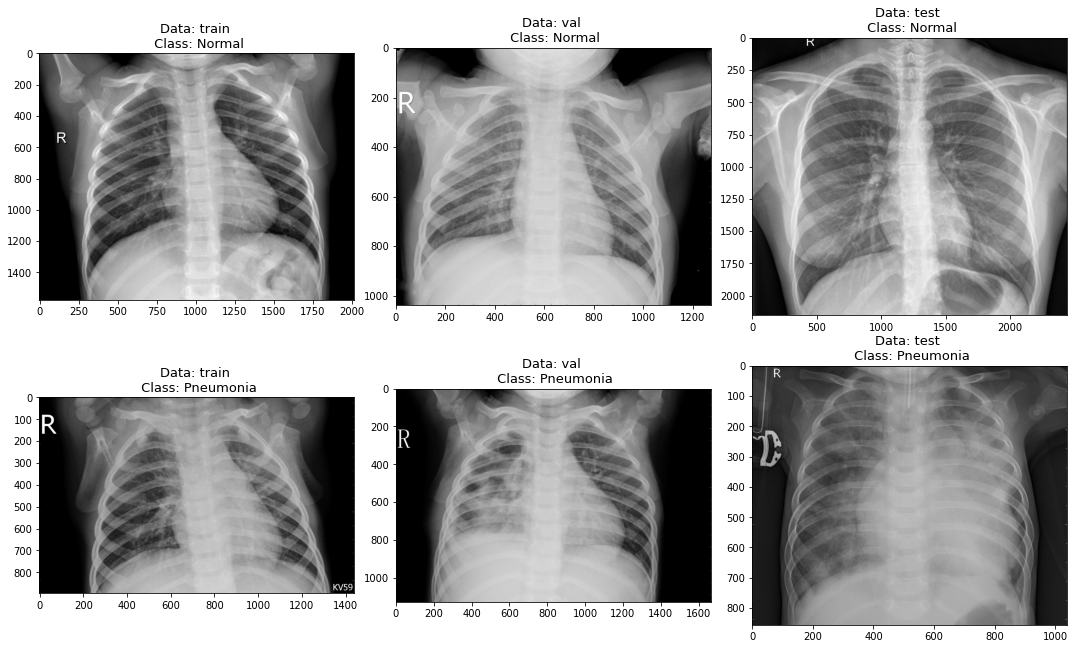

In [4]:
# Check images
fig, ax = plt.subplots(2, 3, figsize = (15, 9))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train','val','test']):
    set_path = data_path.joinpath(_set)
    
    normal_img_path = set_path.joinpath('NORMAL')
    normal_img = plt.imread(normal_img_path.joinpath(os.listdir(normal_img_path)[1]))
    
    pneumonia_img_path = set_path.joinpath('PNEUMONIA')
    pneumonia_img = plt.imread(pneumonia_img_path.joinpath(os.listdir(pneumonia_img_path)[3]))
    
    ax[i].imshow(normal_img, cmap = 'gray')
    ax[i].set_title('Data: {} \n Class: Normal'.format(_set), fontsize = 13)
    ax[i+3].imshow(pneumonia_img, cmap = 'gray')
    ax[i+3].set_title('Data: {} \n Class: Pneumonia'.format(_set), fontsize = 13)

In [5]:
# check class balance
train_normal_cnt = len(os.listdir(data_path.joinpath('train', 'NORMAL')))
train_pneumonia_cnt = len(os.listdir(data_path.joinpath('train', 'PNEUMONIA')))

val_normal_cnt = len(os.listdir(data_path.joinpath('val', 'NORMAL')))
val_pneumonia_cnt = len(os.listdir(data_path.joinpath('val', 'PNEUMONIA')))

test_normal_cnt = len(os.listdir(data_path.joinpath('test', 'NORMAL')))
test_pneumonia_cnt = len(os.listdir(data_path.joinpath('test', 'PNEUMONIA')))

total_normal_cnt = train_normal_cnt + val_normal_cnt + test_normal_cnt
total_pneumonia_cnt = train_pneumonia_cnt + val_pneumonia_cnt + test_pneumonia_cnt

print('Train counts')
print('Normal {} - {} Pneumonia'.format(train_normal_cnt, train_pneumonia_cnt))
print('\nVal counts')
print('Normal {} - {} Pneumonia'.format(val_normal_cnt, val_pneumonia_cnt))
print('\nTest counts')
print('Normal {} - {} Pneumonia'.format(test_normal_cnt, test_pneumonia_cnt))
print('\nTotal counts')
print('Normal {} - {} Pneumonia'.format(total_normal_cnt, total_pneumonia_cnt))

Train counts
Normal 1341 - 3875 Pneumonia

Val counts
Normal 8 - 8 Pneumonia

Test counts
Normal 234 - 390 Pneumonia

Total counts
Normal 1583 - 4273 Pneumonia


#Preprocess

In [6]:
CONFIG = {
    'MEAN': [122.79749774, 122.79749774, 122.79749774],
    'STD': [61.01180544, 61.01180544, 61.01180544],
    'PNEUMONIA_ID': 1,
    'NORMAL_ID': 0,
    'image_dims': (224,224),
    'recalculate_dataset_stats': False,
    'max_pixel_val': 255.0,
    'batch_size': 16,
    'loader_workers': 4,
    'smoothing' : 0.00,
    't1' : 0.8,
    't2' : 1.2,
    'train_pkl_loc': 'train_data.pkl',
    'val_pkl_loc': 'val_data.pkl',
    'test_pkl_loc': 'test_data.pkl',
    'train_df_loc': 'train_df.pkl',
    'val_df_loc': 'val_df.pkl',
    'test_df_loc': 'test_df.pkl',
    
         }

In [12]:
def index_dataset():
    # Index the train, validation, and test subsets into their relevant pandas dataframes. 
    # For each image we store the image class, file name, and file location.
    PNEUMONIA_ID = CONFIG['PNEUMONIA_ID']
    NORMAL_ID = CONFIG['NORMAL_ID']
    def build_df(subset, balance_dataset=False):
        cols = ['Class', 'Name', 'Location']
        rows = [[],[]]
        for cls, cls_id in [('NORMAL', NORMAL_ID), ('PNEUMONIA', PNEUMONIA_ID)]:
            path = data_path.joinpath(subset, cls)
            locs = os.listdir(path)
            for name in locs:
                rows[cls_id].append([cls_id, name, path.joinpath(name)])
        if balance_dataset:
            # If we need to balance the dataset:
            # Replicate the class with lowest representation using the relevant ratio
            ratio = len(rows[PNEUMONIA_ID])/len(rows[NORMAL_ID])
            for i in range(int(ratio)-1):
                rows[NORMAL_ID].extend(rows[NORMAL_ID])
            remaining_diff = len(rows[PNEUMONIA_ID]) - len(rows[NORMAL_ID])
            rows[NORMAL_ID].extend(rows[NORMAL_ID][:remaining_diff])
            print('NORMAL: {}   -  PNEUMONIA: {}'.format(len(rows[NORMAL_ID]), len(rows[PNEUMONIA_ID])))
        rows[NORMAL_ID].extend(rows[PNEUMONIA_ID])
        rows = rows[NORMAL_ID]
        random.shuffle(rows)
        return pd.DataFrame(rows, columns=cols)
    
    train_df = build_df('train', balance_dataset=True)
    val_df = build_df('val')
    test_df = build_df('test')
    return train_df, val_df, test_df

def convert_dataset_to_list(df, save_loc, save_df_loc):
    # During development we noticed that the whole dataset can fit into RAM. 
    # Therefore, we load all the images into a dictionary using the same indexing as the dataframe.
    # To reduce memory usage, we resize the images beforehand, instead of performing that as part of the augmentation pipeline.
    path = Path(save_loc)
    path_df = Path(save_df_loc)
    if not path.exists():
        rsz = trf.Resize(CONFIG['image_dims'])
        new_dataset = {}
        with tqdm.tqdm(total=len(df)) as pbar:
            for index, row in df.iterrows():
                image_location = row['Location']
                image = Image.open(image_location).convert('RGB')
                image = rsz(image)
                new_dataset[index] = image
                pbar.update(1)
        joblib.dump(new_dataset, path)
        joblib.dump(df, path_df)
    new_dataset = None
    gc.collect()
    new_dataset = joblib.load(path)
    new_df = joblib.load(path_df)
    return new_dataset, new_df
    
        

def calculate_dataset_stats(locations_df):
    # Calculate mean and std of input dataframe images
    length = len(locations_df)
    print(length)
    img_stack = []
    for idx in range(length):
        img = Image.open(locations_df.iloc[idx]['Location']).convert('RGB')
        rsz = trf.Resize(CONFIG['image_dims'])
        img2 = rsz.forward(img)
        img_stack.append(np.array(img2))

    img_stack = np.stack(img_stack)
    img_stack = np.einsum('ijkl->lijk', img_stack).reshape((3,-1))
    mean = np.mean(img_stack, -1)
    std = np.std(img_stack, -1)
    
    CONFIG['MEAN'] = mean
    CONFIG['STD'] = std
    print(mean, std)

In [15]:
train_df, val_df, test_df = index_dataset()
if CONFIG['recalculate_dataset_stats']:
    calculate_dataset_stats(train_df)
train_data, train_df = convert_dataset_to_list(train_df, CONFIG['train_pkl_loc'], CONFIG['train_df_loc'])
val_data, val_df = convert_dataset_to_list(val_df, CONFIG['val_pkl_loc'], CONFIG['val_df_loc'])
test_data, test_df = convert_dataset_to_list(test_df, CONFIG['test_pkl_loc'], CONFIG['test_df_loc'])
gc.collect()

NORMAL: 3875   -  PNEUMONIA: 3875


100%|██████████| 624/624 [02:46<00:00,  3.74it/s]


0

In [13]:
class XRayDataset(Dataset):
    """
    Class to read and load the XRay dataset from disk
    """
    def __init__(self, df, transform=None, fmix=False, data=None):
        self.transform = transform
        self.df = df
        self.fmix = fmix
        self.fmix_params={
                     'alpha': 1.0, 
                     'decay_power': 3.0, 
                     'shape': CONFIG['image_dims'],
                     'max_soft': True, 
                     'reformulate': False
                 }
        self.data = data

    def __len__(self):
        return len(self.df)
    
    def transform_image(self, img):
        if self.transform is not None:
            return self.transform(img)
    
    def __getitem__(self, idx):
        if self.data is None:
            image_location = self.df.iloc[idx]['Location']
            image = Image.open(image_location).convert('RGB')
        else:
            image = self.data[idx]
        image = self.transform_image(image)
        label = self.df.iloc[idx]['Class']              
        return image, label

## Data Augmentation

In [14]:
def get_train_transforms():
    mean = np.array(CONFIG['MEAN']) / CONFIG['max_pixel_val']
    std = np.array(CONFIG['STD']) / CONFIG['max_pixel_val']
    return trf.Compose([
#             trf.Resize(CONFIG['image_dims']),
            trf.ColorJitter(brightness=0.2, contrast=0.1),
            trf.RandomAffine(degrees=20.0, translate=None, scale=None),
            trf.ToTensor(),
            trf.Normalize(mean, std)
        ])

def get_eval_transforms():
    mean = np.array(CONFIG['MEAN']) / CONFIG['max_pixel_val']
    std = np.array(CONFIG['STD']) / CONFIG['max_pixel_val']
    return trf.Compose([
            trf.Resize(CONFIG['image_dims']),
            trf.ToTensor(),
            trf.Normalize(mean, std)
        ])

1. Randomly alter the brightness of the x-ray by up to 20%
2. Randomly alter the contrast by up to 10%
3. Randomly rotate the x-ray by up to 20 degrees

## Data Loader

In [16]:
def get_data_loaders(train_df, val_df, test_df, train_data, val_data, test_data):
    eval_transforms = get_eval_transforms()
    
    train = XRayDataset(train_df, transform=get_train_transforms(), fmix=False, data=train_data)
    val = XRayDataset(val_df, transform=get_eval_transforms(), data=val_data)
    test = XRayDataset(test_df, transform=get_eval_transforms(), data=test_data)
    
    train_loader = DataLoader(train, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=CONFIG['loader_workers'], drop_last=False)
    val_loader = DataLoader(val, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=CONFIG['loader_workers'], drop_last=False)
    test_loader = DataLoader(test, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=CONFIG['loader_workers'], drop_last=False)
    
    return train_loader, val_loader, test_loader


In [17]:
train_loader, val_loader, test_loader = get_data_loaders(train_df, val_df, test_df, train_data, val_data, test_data)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Model: Pre-Trained Vision Transformer

In [19]:
class ViTModel(nn.Module):
    def __init__(self):
        super(ViTModel, self).__init__()
        self.feature_extractor = timm.create_model('vit_small_resnet50d_s3_224', num_classes=2, attn_drop_rate=0.0, drop_path_rate=0.0,pretrained=True)

    def forward(self, x):
        out = x
        out = self.feature_extractor(out)  
        return out